# Regularización

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 9/12/2025

> Asignatura: Programación para la Inteligencia Artificial

Vamos a hablar explícitamente de un tema que ya se ha tratado de manera tangencial: las técnicas de regularización. La definición de regularizador es algo ambigua, pero generalmente se consideran técnicas de regularización todas aquellas destinadas a mejorar la capacidad de generalización de un modelo. Ya hemos comentado algunas explícitamente (*Dropout*, Parada Temprana y Aumentado de Datos) y otras de pasada (*weight decay*).

Vamos a rescatarnos código del cuaderno anterior. Uno en el que haya un buen sobreajuste.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def learning_loop_for_classification(train_dataloader, val_dataloader, model, epochs, loss_fn, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [3]:
DRIVE=False
if DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'
else:
  workpath = '/workspace/data'

In [4]:
device = 'cuda'
device = torch.device("cuda:0" if (device == 'cuda') and torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class CudaDataset(Dataset):
  def __init__(self, dataset, device, transform = None):
    self.dataset = dataset
    self.cuda_y = []
    self.cuda_x = []
    self.device = device
    self.transform = transform

    for x, y in tqdm(self.dataset, desc="Moving to GPU"):
      self.cuda_x.append(x.to(self.device))
      self.cuda_y.append(torch.tensor(y, device=self.device))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if self.transform is None:
      x = self.cuda_x[idx]
    else:
      x = self.transform(self.cuda_x[idx])
    return x, self.cuda_y[idx]

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

In [6]:
transforms_policy = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root=workpath, train=True, download=True, transform=transforms_policy)
val_dataset = datasets.CIFAR10(root=workpath, train=False, download=True, transform=transforms_policy)

In [7]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")

Número de ejemplos en entrenamiento: 50000
Número de ejemplos en validación: 10000


In [8]:
learning_rate = 1e-3
epochs = 200
batch_size = 1024
loss_fn = torch.nn.CrossEntropyLoss()
validation_freq = 1

if not str(device)=="cpu":
  val_dataset = CudaDataset(val_dataset, device)
  train_dataset = CudaDataset(train_dataset, device)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

Moving to GPU: 100%|██████████| 50000/50000 [00:07<00:00, 6869.29it/s]


In [9]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )


model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:46<00:00,  4.27it/s, loss=0.5220980644226074]


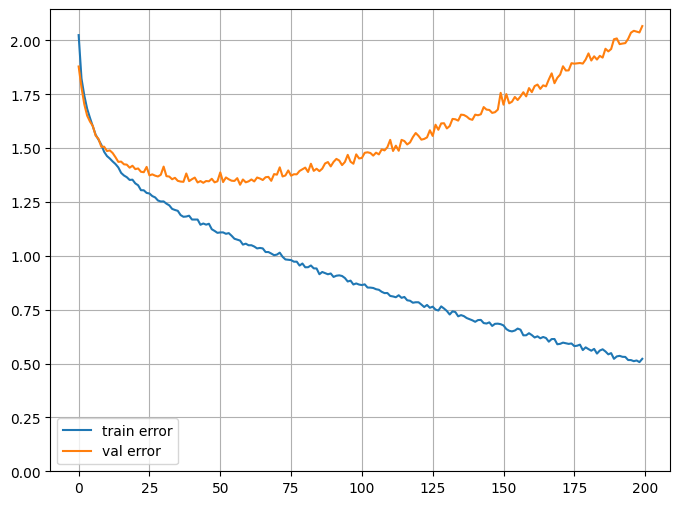

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Un sobreajuste obvio a partir de la época 50.

El sobreajuste es una consecuencia de que la red aprenda *demasiado bien*. Encuentra pesos que son cada vez mejores para minimizar la función de pérdida para el conjunto de entrenamiento. El problema es que el conjunto de entrenamiento es normalmente solo un subconjunto del problema. Un *subproblema* que puede aprender a resolver muy bien al precio de funcionar peor para otros casos. 

La Parada Temprana es una manera de evitar el sobreajuste deteniendo el aprendizaje cuando lo empezamos a detectar. No impone condicionantes al entrenamiento para prevenir o disiminuir el sobreajuste, sino que lo detiene. Típicamente las otras regularizaciones actúan de dos maneras: complicando el aprendizaje de la red para que no pueda sobreajustarse al conjunto de entrenamiento o expandiendo el conjunto de entrenamiento.

## Condicionar el aprendizaje de la red

Una de las vías para obtener una mejor generalización de los resultados es condicionar el aprendizaje de la red. En esencia esto consiste en añadirle restricciones a dicho aprendizaje. ¿Cómo? Normalmente añadiendo componentes a la función de pérdida para que el entrenamiento no se guíe únicamente por la "función de pérdida del problema". 

¿Qué condiciones? En realidad eso depende de las necesidades. La divergencia de Kullback-Leibler, por ejemplo, es un término regularizador en el contexto del Variational Autoencoder (Práctica 3 Ejercicio 2). Distintas funciones pueden servir como regularizadores en distintos problemas, pero la idea general es común: añadir más criterios que se tengan que tener en cuenta durante el entrenamiento.

Algunos regularizadores comunes a diversos problemas son los que condicionan el tamaño de los pesos. ¿Por qué? Porque pesos grandes pueden (aunque no necesariamente) provocan sobreentrenamiento. Reducir el tamaño de los pesos es una técnica habitual, por tanto, de reducir el sobreentrenamiento.

¿Por qué los pesos grandes dan problemas? Los pesos grandes pueden amplificar cambios pequeños que en el conjunto de entrenamiento se compensa, pero con otros ejemplos no.

Imaginemos dos neuronas con cuatro entradas cuyos pesos en el caso A son (1000, -1000, 500 y 500) y en el caso B son (0.1, -0.1, 0.05, 0.05) y su activación es una función sigmoide. Conocemos cuatro datos durante el entrenamiento para los que dicha neurona debe tener una salida de 0.5 y ambas neuronas se ajustan bien.

Entrenamiento 

| Entradas | Neurona A | Neurona B |
|----------|----------|----------|
| 1,1,0,0  |$s(0)=0.5$ | $s(0)=0.5$ |
| 0,1,1,1  | $s(0)=0.5$ | $s(0)=0.5$ |
| 1,0,-1,-1 | $s(0)=0.5$ | $s(0)=0.5$ |
| 0,-1,-1,-1 | $s(0)=0.5$ | $s(0)=0.5$ |

Ahora asumamos que tras el entrenamiento se introducen unas entradas ligeramente distintas para las que se espera una salida similar (0.5).

Test

| Entradas | Neurona A | Neurona B |
|----------|----------|----------|
| 1.1,1,0,0  |$s(100)=1$ | $s(0.01)=0.5025$ |
| 0,1.1,1,1  | $s(-100)=0$ | $s(-0.01)=0.4975$ |
| 1,0,-1.1,-1 | $s(-50)=0$ | $s(-0.005)=0.4988$ |
| 0,-1,-1,-1.1 | $s(-50)=0$ | $s(-0.005)=0.4988$ |

En ambos casos (neurona A y B) los datos de entrenamiento se ajustan perfectamente, sin embargo, A tiene como resultado unos cambios radicales ante pequeños cambios de las entradas (que a priori no se justifican con los datos de entrenamiento) mientras que B tiene unos resultados que parecen más razonables.

### Regularización L2

La regularización L2 consiste en añadir un término que penalice el tamaño de los pesos para que la red tienda a ajustarse a pesos con valores más pequeños. En el ejemplo anterior, aplicando la regularización L2 la solución de la neurona A tendría un valor de pérdida mayor que la neurona B.

$$L_{l2}(w) = \lambda \sum_{i=0}^n w^2_{i} $$

¿Resulta el concepto familiar? Vimos algo parecido al estudiar los optimizadores en detalle: el decremento de los pesos (*weight decay*) que intentaba reducir el tamaño de los pesos en cada paso de ajuste.

De hecho, para el optimizador SGD es equivalente aplicar *weight decay* que incluir una regularización L2.

Recordemos cómo afectaba el *weight decay* al ajuste de los pesos (por simplicidad para un único peso y suponiendo que el gradiente de la función de pérdida que se basa solo en los datos fuera 0):

$$\Delta g_{t,i} = \frac{\partial L}{\partial w_{t,i}} + \lambda w_{t,i}$$

$$w_{t+1,i} = w_{t,i} - \gamma \Delta g_{t,i}$$

$$w_{t+1,i} = w_{t,i} - \gamma \frac{\partial L}{\partial w_{t,i}} - \gamma \lambda w_{t,i}$$

Como hemos dicho que el gradiente de la pérdida es 0...

$$w_{t+1,i} = w_{t,i} - \gamma \lambda w_{t,i}$$

Ahora planteemos el gradiente de una hipotética función de pérdida $L = L_{data} + L_{l2}$ (de nuevo para un solo peso por simplicidad):

$$L = L_{data} + \lambda w^2_{i}$$

$$\frac{\partial L}{\partial w_{t,i}} = \frac{\partial L_{data}}{\partial w_{t,i}}  + 2\lambda w_{t,i}$$

Como hemos asumido que el gradiente de la función de pérdida que se basa en los datos es 0...

$$\frac{\partial L}{\partial w_{t,i}} = 2\lambda w_{t,i}$$

Y la actualización del SGD queda:

$$w_{t+1,i} = w_{t,i} - \gamma 2 \lambda w_{t,i}$$

¡Es lo mismo multiplicado por 2! Y esa multiplicación puede incluirse en el hiperparámetro $\lambda$ así que es equivalente.

¡OJO! Esta equivalencia se aplica al SGD (y a otros optimizadores), pero no al Adam. Aunque el Adam incluye en su implementación de Pytorch el *weight decay*, incluye ese término en el cálculo de los *momentums*, lo que rompe la equivalencia con la regularización L2. En ese sentido, el Adam no realiza un *weight decay* apropiadamente, por eso existe el optimizador AdamW (https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html) que sí desacopla el *weight decay* del cálculo de los *momentums*. Es un detalle a tener en cuenta respecto al Adam.

Dado que usar el *weight decay* del Adam no es equivalente a la regularización L2, vamos a implementarla como una función de pérdida separada y a incluirla en el bucle de entrenamiento para nuestro experimento.

In [11]:
def learning_loop_for_classification_with_L2(train_dataloader, val_dataloader, model, epochs, loss_fn, lambda_l2, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_without_l2_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()

        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.sum(param ** 2)
        loss = loss_fn(y_pred, y_true) + lambda_l2 * l2_reg
        
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_without_l2_step_loss_list=[]
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            l2_reg = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_reg += torch.sum(param ** 2)
            loss_val_without_l2 = loss_fn(y_pred, y_true)
            loss_val = loss_val_without_l2 + lambda_l2 * l2_reg
            val_step_loss_list.append(loss_val)
            val_without_l2_step_loss_list.append(loss_val_without_l2)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_without_l2 = torch.tensor(val_without_l2_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_without_l2_loss_list.append(val_without_l2)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_without_l2_loss_list, val_acc_list

In [12]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

lambda_l2 = 1e-4

model, train_loss_list, val_loss_list, val_without_l2_loss_list, val_acc_list = learning_loop_for_classification_with_L2(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    lambda_l2,
    optimizer,
    validation_freq = validation_freq)

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

epoch: 100%|██████████| 200/200 [00:53<00:00,  3.72it/s, loss=0.8836502432823181]


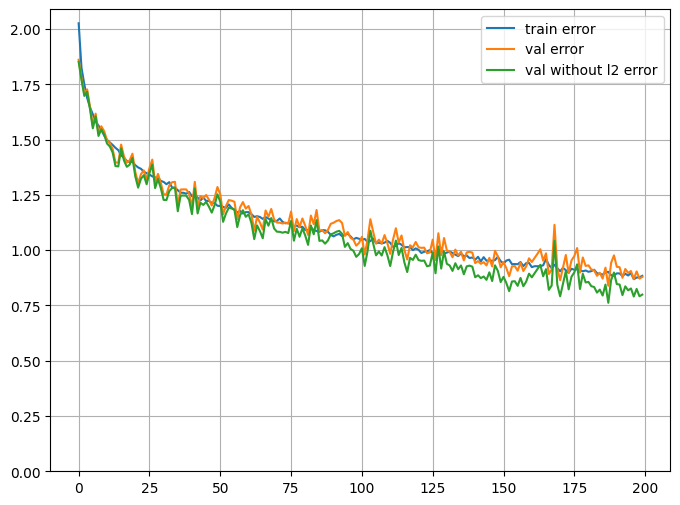

In [13]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.plot(range(0, validation_freq*len(val_without_l2_loss_list), validation_freq), [l.cpu() for l in val_without_l2_loss_list], label="val without l2 error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

¡Parece que disminuye el sobreajuste!

### Max-Norm

El objetivo del Max-Norm es impedir que los pesos crezcan demasiado, pero atajando el problema directamente. La idea es forzar a que la Norma-2 de los pesos de cada neurona no supere un valor $r$ dado.

$$\|w\|_{2} < r$$

En caso de superarlo, se reajustan los pesos para que, manteniendo sus valores relativos, cumplan la restricción.

Vamos a implementarlo y a crear otro bucle de entrenamiento que lo incluya.

In [14]:
def max_norm(model, max_value=3.0):
    for name, param in model.named_parameters():
        if "weight" in name:
            with torch.no_grad():
                # Calcula norma L2 por fila (una fila = una neurona)
                norms = param.norm(p=2, dim=1, keepdim=True)
                desired = torch.clamp(norms, 0, max_value)
                param *= (desired / (1e-8 + norms))

def learning_loop_for_classification_with_max_norm(train_dataloader, val_dataloader, model, epochs, loss_fn, r_max_norm, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
        max_norm(model, max_value=r_max_norm)
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [15]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

r_max_norm = 2

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification_with_max_norm(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    r_max_norm,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:49<00:00,  4.07it/s, loss=0.780468225479126] 


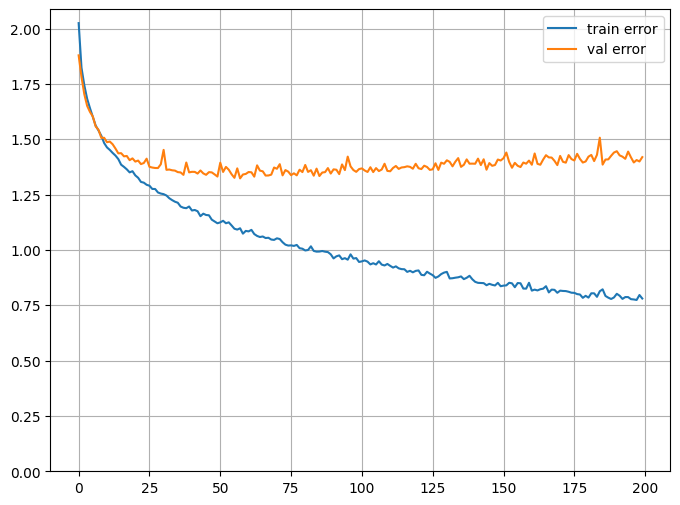

In [16]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

¡Parece que el ajuste por las bravas también ayuda! 

### Regularización L1

La regularización L1 es otra regularización muy conocida y puede parecer que tiene un uso parecido a la L2, pero las apariencias engañan.

$$L_{l1}(w) = \lambda \sum_{i=0}^n |w_{i}|$$

Como se puede observar, la regularización L1 penaliza el tamaño de los pesos en base al valor absoluto. Uno intuitivamente podría pensar que esto produce el mismo efecto que la L2 y no andaría muy desencaminado, pero hay algunas diferencias que hacen que su uso cambie.

Para empezar vamos a implementarla de manera similar a la L2 y ver su efecto.

In [17]:
def learning_loop_for_classification_with_L1(train_dataloader, val_dataloader, model, epochs, loss_fn, lambda_l1, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_without_l1_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()

        l1_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_reg += torch.sum(torch.abs(param))
        loss = loss_fn(y_pred, y_true) + lambda_l2 * l1_reg
        
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_without_l1_step_loss_list=[]
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            l1_reg = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_reg += torch.sum(torch.abs(param))
            loss_val_without_l1 = loss_fn(y_pred, y_true)
            loss_val = loss_val_without_l1 + lambda_l1 * l1_reg
            val_step_loss_list.append(loss_val)
            val_without_l1_step_loss_list.append(loss_val_without_l1)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_without_l1 = torch.tensor(val_without_l1_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_without_l1_loss_list.append(val_without_l1)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_without_l1_loss_list, val_acc_list

In [18]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

lambda_l1 = 1e-4

model, train_loss_list, val_loss_list, val_without_l2_loss_list, val_acc_list = learning_loop_for_classification_with_L1(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    lambda_l1,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:53<00:00,  3.76it/s, loss=1.3770924806594849]


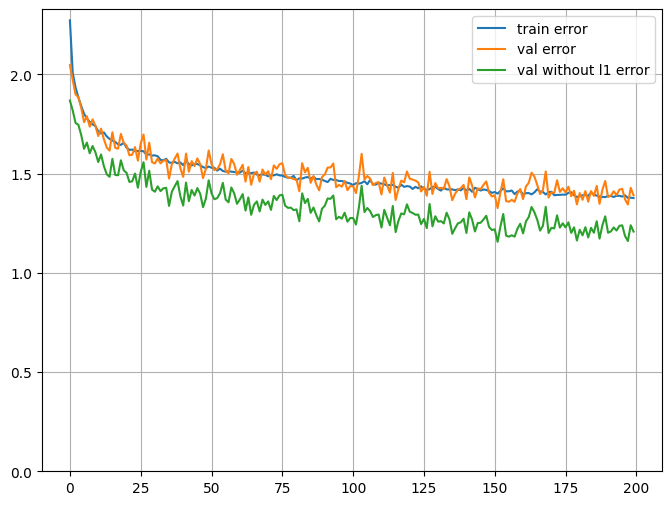

In [19]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.plot(range(0, validation_freq*len(val_without_l2_loss_list), validation_freq), [l.cpu() for l in val_without_l2_loss_list], label="val without l1 error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Como vemos, tiene un efecto similar a L2 aunque el efecto de la L1 en el valor de la pérdida es "mayor".

Como hemos visto antes, la derivada de la L2 es $2\lambda w_{t,i}$, por lo que empuja a los pesos a 0 de manera proporcional al valor de los mismos. Sin embargo, la derivada de la L1 es una función definida por partes (recordemos la derivada del error absoluto):

$$L1(x) dx = \left\{ \begin{array}{lcc} \lambda & si & x > 0 \\ \\ -\lambda & si & x < 0 \\ \\ indefinida & si & x = 0 \end{array} \right.$$

La L1 no suaviza su empuje si los pesos se acercan a 0 ni lo aumenta si se alejan. Empuja siempre igual. De hecho, solo dejaría de empujar en el hipotético caso de que la derivada en el 0 se defina como 0 (que es lo que hace Pytorch con la derivada de torch.abs()). Por lo tanto el comportamiento será "empujar" los pesos hacia 0 hasta que sean 0 y el término de la regularización se anule en la derivada. Que un peso salga de 0 es dificil una vez esté ahí.

La L1 se utiliza para buscar generar *sparsity*. Esto es hacer que muchos pesos se vuelvan 0. Esto es deseable en ocasiones. Un modelo en el que muchos pesos son 0 puede ocupar menos espacio y es más interpretable, por ejemplo.

¿Qué ocurre? Que la implementación que hemos hecho no es muy buena generando un modelo *sparse*. Recordemos que la derivada de la L1 empuja de manera *constante*. Es improbable que restando un valor constante sumado al gradiente (y los demás factores del Adam) un peso se reduzca a exactamente 0 y, aunque lo hiciera, el el *momentum* acumulado probablemente lo sacaría del 0. Vamos a ver el ratio de *sparsity*:

In [20]:
def model_sparsity(model, threshold=1e-6):
    total_params = 0
    zero_params = 0
    
    for p in model.parameters():
        if p.requires_grad:
            total_params += p.numel()
            zero_params += (p.abs() < threshold).sum().item()
    
    sparsity = zero_params / total_params
    return sparsity

In [21]:
print(model_sparsity(model))

0.006649705943873953


Para conseguir que la L1 haga "su trabajo" vamos a tener que ser más bruscos.

Para empezar vamos a tener que aplicar un umbral suave (*soft threshold*). La idea es que si los pesos "cruzan" el 0, los dejemos en 0 y definimos nuestra L1 así sobre los propios pesos.

$$\widehat{L1}(w) = sign(w)max(|w|-\lambda, 0)$$

Esto implica no aplicar la L1 como una parte de la función de pérdida, sino manipular los pesos directamente como en la Max-Norm. Vamos a escribirlo en una función de Pytorch y a crearnos un bucle de entrenamiento que la use.

In [22]:
def apply_l1_soft_threshold(model, lambda_l1):
    with torch.no_grad():
        for p in model.parameters():
            p.copy_(torch.sign(p) * torch.clamp(p.abs() - lambda_l1, min=0.0))

def learning_loop_for_classification_with_L1_soft_threshold(train_dataloader, val_dataloader, model, epochs, loss_fn, lambda_l1, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []
  sparsity_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
        apply_l1_soft_threshold(model, lambda_l1)
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))
      sparsity_list.append(model_sparsity(model))
  return model, epoch_loss_list, val_loss_list, sparsity_list, val_acc_list

In [23]:
torch.manual_seed(0)

epochs = 200

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

lambda_l1 = 1e-4

model, train_loss_list, val_loss_list, sparsity_list, val_acc_list = learning_loop_for_classification_with_L1_soft_threshold(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    lambda_l1,
    optimizer,
    validation_freq = validation_freq)

epoch:   0%|          | 1/200 [00:00<00:51,  3.83it/s, loss=2.030319929122925]

epoch: 100%|██████████| 200/200 [00:51<00:00,  3.90it/s, loss=1.6245685815811157]


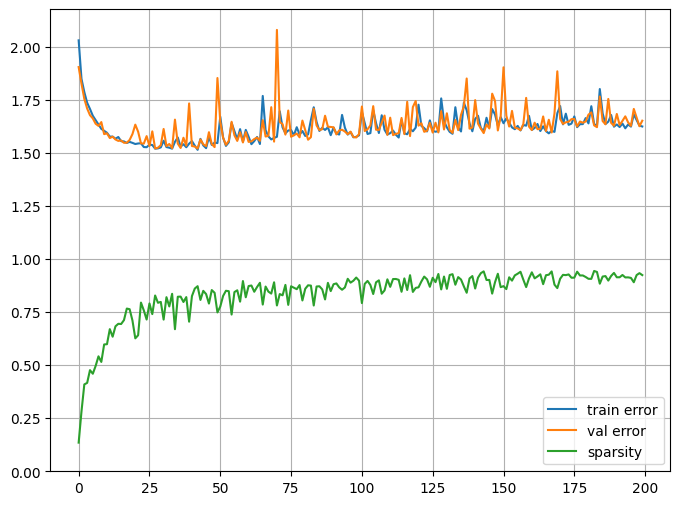

In [24]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.plot(range(len(sparsity_list)), [l for l in sparsity_list], label="sparsity")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Un *sparsity* tremendo y un entrenamiento... inestable por decir algo. Podemos ver que a partir de la época 25 el modelo más que aprender, desaprende. Eso sí, sin sobreajuste. Rebajando el valor de $\lambda$ podemos suavizar ese comportamiento aunque este es un buen ejemplo didáctico.

 Vamos a probar con un SGD para que no haya *momentums* interviniendo.

In [25]:
torch.manual_seed(0)
epochs = 5000

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
  )

lambda_l1 = 1e-6

model, train_loss_list, val_loss_list, sparsity_list, val_acc_list = learning_loop_for_classification_with_L1_soft_threshold(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    lambda_l1,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 5000/5000 [21:23<00:00,  3.90it/s, loss=1.7288960218429565]


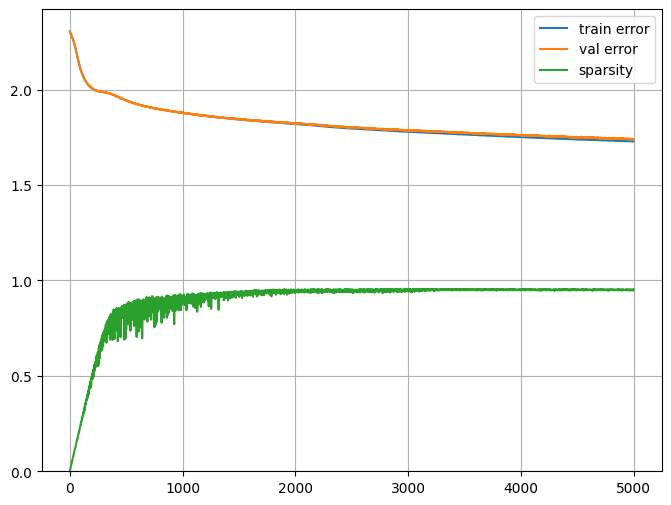

In [26]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.plot(range(len(sparsity_list)), [l for l in sparsity_list], label="sparsity")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

## Expandir el conjunto de entrenamiento

Los regularizadores basados en expandir el conjunto de entrenamiento ya los hemos visto en el Aumentado de Datos. Ahora vamos a ver otro.

### Condicionante de Consistencia

Entendemos por un regularizador que condicione la consistencia una función de pérdida que, dado un modelo $m_{\theta}$ y un ejemplo (o lote de ejemplos) $(x,y_{true})$, funciona como sigue:

$$y_{pred} = m_{\theta}(x)$$

$$\hat{x} = x+ \epsilon$$

con $\epsilon$ algún tipo de ruido.

$$\widehat{y_{pred}} = m_{\theta}(\hat{x})$$

$$L_{CC}=D(\widehat{y_{pred}}, y_{pred} )$$

Siendo $D$ alguna función que permita medir la distancia entre $\widehat{y_{pred}}$ y $y_{pred}$ (MSE, L1, BCE o incluso Kullback-Leibler pueden ser opciones según el caso).

La idea es sencilla: condicionar la red para que se comporte de la misma manera cuando las entradas son parecidas. Si entendemos la noción de ruido de manera ámplia (alteraciones a la imagen), este regularizador puede ser muy parecido al Data Augmentation. Sin embargo, el condicionante de consistencia no implica que el resultado $\widehat{y_{pred}}$ sea $y_{true}$ como sí hace el Data Agumentation. Al contrario. Si la red falla para un ejemplo $x$, este regularizador penalizará que se acierte para $\hat{x}$ y premiará que se falle mientras se cometa el mismo fallo.

Vamos a implementar un bucle de entrenamiento con una versión sencilla de este regularizador.

In [27]:
def learning_loop_for_classification_with_consistency(train_dataloader, val_dataloader, model, epochs, loss_fn, consistency_loss_fn, noise_fn, lambda_consistency, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()

        loss = loss_fn(y_pred, y_true)
        x_with_noise = noise_fn(x_true)
        y_pred_c = model(x_with_noise)
        consistency_loss = consistency_loss_fn(y_pred_c, y_pred)
        total_loss = loss + lambda_consistency*consistency_loss

        total_loss.backward()                                     # Backward
        steps_loss_list.append(total_loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [30]:
torch.manual_seed(0)

epochs = 200

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

consistency_loss_fn = nn.MSELoss()
lambda_consistency = 2
# No confundir la lambda función con el hiperparámetro lambda que define la relevancia del regularizador.
noise_fn = lambda x, sigma=0.1: torch.clamp(x + torch.randn_like(x) * sigma, 0, 1) 

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification_with_consistency(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    consistency_loss_fn, 
    noise_fn, 
    lambda_consistency,
    optimizer,
    validation_freq = validation_freq)

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

epoch: 100%|██████████| 200/200 [00:55<00:00,  3.61it/s, loss=0.9064118266105652]


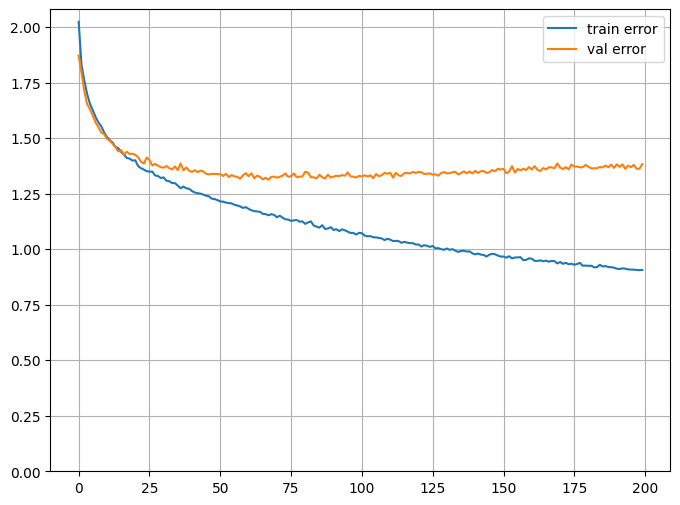

In [31]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

No hace maravillas, pero reduce el sobreajuste :)

## Conclusiones

Lo más relevante es el concepto de regularizador y qué clase de formas puede tomar. Dado que no existe una solución general para la generalización, es extremadamente común que se añadan funciones a la función de pérdida para que actúen como regularizadores en esos contextos concretos. Técncias como la L1 y la L2 son regularizadores bastante habituales según el campo de problemas y técnicas de regularización más "agresivas" como el *Dropout* son también recursos habituales.